In [1]:
import pymc as pm
import arviz as az

In [2]:
!pip freeze | grep arviz

arviz==0.15.1


In [3]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns

In [4]:
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings

messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

for m in messages:
    warnings.filterwarnings("ignore", message=m)

In [5]:
n_theta = 10000

# generate 10,000 values from Beta(2,5)
theta = np.random.beta(2,5,n_theta) 
print("First five  values of theta:\n\t", theta[0:5])
print("Sample mean:\n\t", np.mean(theta))
print("The 2.5% and 97.5% of quantiles:\n\t", np.percentile(theta,[2.5,97.5])) 

First five  values of theta:
	 [0.06573117 0.48941024 0.04208121 0.44506514 0.35321151]
Sample mean:
	 0.2849420434266293
The 2.5% and 97.5% of quantiles:
	 [0.04392104 0.6454641 ]


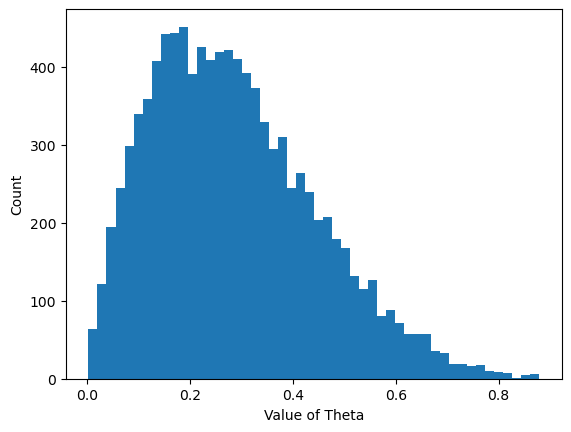

In [6]:
plt.hist(theta,50)
plt.xlabel("Value of Theta")
plt.ylabel("Count")
plt.show()

First 5 heads/tails values (tails=0, heads=1)
	 [0 0 0 1 1 1 1 0 0 0]
Overall frequency of Tails and Heads, accounting for uncertainty about theta itself
	 [0.7147 0.2853]


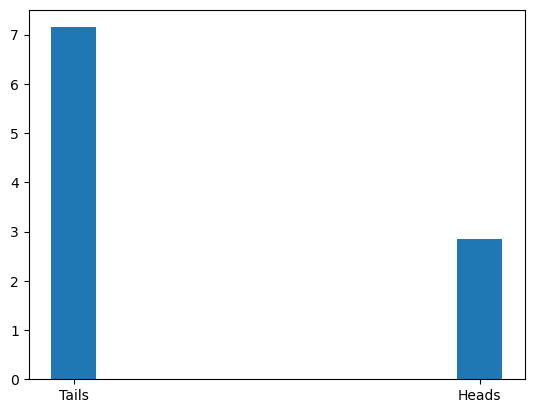

In [7]:
# simulate y from posterior predictive distribution
y = np.random.binomial(1, theta, n_theta) # generate a heads/tails value from each of the 10,000 thetas
# random.binomial(n, p, size=None)
# runs n times, return the number of success 
# p float or array_like of floats Parameter of the distribution, >= 0 and <=1.


print("First 5 heads/tails values (tails=0, heads=1)\n\t", y[0:10])
print("Overall frequency of Tails and Heads, accounting for uncertainty about theta itself\n\t", np.bincount(y)/10000)
# np.bincount Count number of occurrences of each value in array of non-negative ints.

plt.hist(y, density=True)
# If True, draw and return a probability density: 
# each bin will display the bin's raw count divided by the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins)))
plt.xticks([.05,.95],["Tails","Heads"])
# !!!!!!!!!!!
plt.show()

## Rejection sampling and Weighted bootstrap

Example adapted from https://wiseodd.github.io/techblog/2015/10/21/rejection-sampling/

In [8]:
sns.set()

def h(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)
# x: This parameter represents the values at which you want to calculate the PDF. 
# It can be a single value, an array-like object, or a NumPy array. 
# The PDF represents the probability density at each value of x, indicating the likelihood of observing that value according to the specified normal distribution.

def g(x):
    return st.norm.pdf(x, loc=50, scale=30)


x = np.arange(-50, 151)
M = max(h(x) / g(x))  # for rejection sampling

h is a mixture of two normal distributions (unnormalized), and density h is a normal distribution with mean 50 and standard deviation 30.

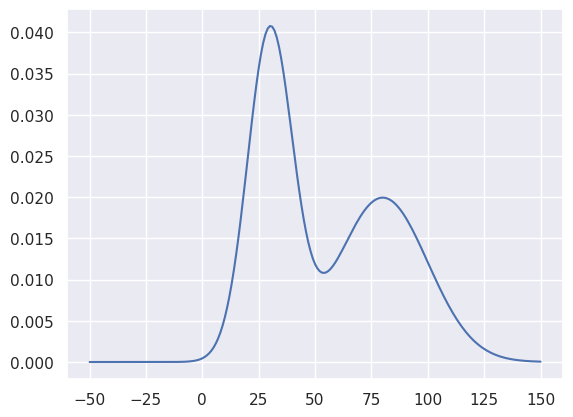

In [9]:
plt.plot(x, h(x))
plt.show()

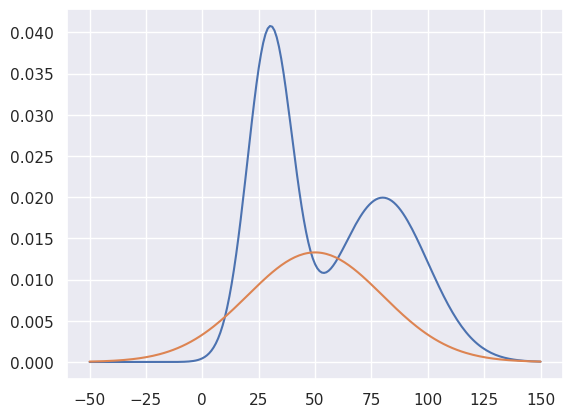

In [10]:
# Superimpose h and g on same plot
plt.plot(x,h(x))
plt.plot(x,g(x))
plt.show()

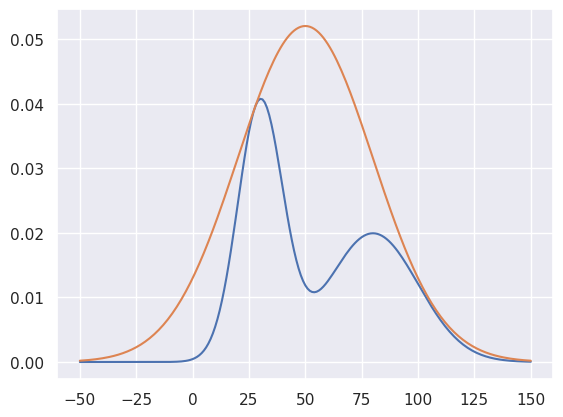

In [11]:
# Superimpose h and M*g on same plot - now M*g envelopes h
plt.plot(x,h(x))
plt.plot(x,M*g(x))
plt.show()

Rejection rate is 49.64753272910373


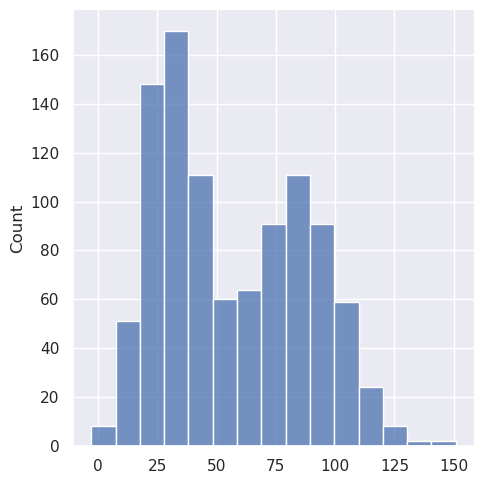

In [12]:
def rejection_sampling(maxiter=10000,sampsize=1000):
    samples = []
    sampcount = 0  # counter for accepted samples
    maxcount = 0   # counter for proposal simulation
    # sampcount/maxcount at any point in the iteration is the acceptance rate

    while (sampcount < sampsize and maxcount < maxiter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, 1)
        maxcount += 1

        if u <= h(z)/(M*g(z)):
            samples.append(z)
            sampcount += 1
    
    print('Rejection rate is',100*(1-sampcount/maxcount))
    if maxcount == maxiter: print('Maximum iterations achieved')
    return np.array(samples)

s = rejection_sampling(maxiter=10000,sampsize=1000)
sns.displot(s)
# Figure-level interface for drawing distribution plots onto a FacetGrid.
# This function provides access to several approaches for visualizing the univariate or bivariate distribution of data
# The kind parameter selects the approach to use: histplot() (with kind="hist"; the default) kdeplot() (with kind="kde") ecdfplot() (with kind="ecdf"; univariate-only)


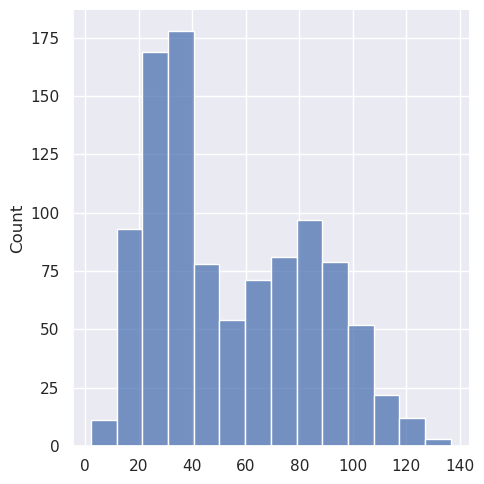

In [13]:
# weighted bootstrap computation involving h and g
import random

def weighted_bootstrap(iter=1000,size=100):
    w = []
    y = []
    
    for i in range(iter):
        z = np.random.normal(50, 30)
        y.append(z)
        wz = h(z)/g(z)
        w.append(wz)
        
    v = random.choices(y,weights=w,k=size) # do not need to renormalize w
    return np.array(v)

wb = weighted_bootstrap(iter=10000,size=1000)
sns.displot(wb)

## Beetles

In [14]:
beetles_x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
beetles_x_mean = beetles_x - np.mean(beetles_x)
beetles_n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
beetles_y = np.array([6, 13, 18, 28, 52, 53, 61, 60])
beetles_N = np.array([8]*8)

In [15]:
from scipy.special import expit
expit(2)
# expit(x) = 1/(1+exp(-x))

# pm.math.invlogit(x) = expit(x)

0.8807970779778823

In [16]:
with pm.Model() as beetle_model:
    # The intercept (log probability of beetles dying when dose=0)
    # is centered at zero, and wide-ranging (easily anywhere from 0 to 100%)
    # If we wanted, we could choose something like Normal(-3,2) for a no-dose
    # death rate roughly between .007 and .25
    alpha_star = pm.Normal('alpha*', mu=0, sigma=100)
    # the effect on the log-odds of each unit of the dose is wide-ranging:
    # we're saying we've got little idea what the effect will be, and it could
    # be strongly negative.
    beta = pm.Normal('beta', mu=0, sigma=100)
    
    # given alpha, beta, and the dosage, the probability of death is deterministic:
    # it's the inverse logit of the intercept+slope*dosage
    # Because beetles_x has 8 entries, we end up with 8 p_i values
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha_star + beta*beetles_x_mean))
    
    # finally, the number of bettles we see killed is Binomial(n=number of beetles, p=probability of death)
    deaths = pm.Binomial('obs_deaths', n=beetles_n, p=p_i, observed=beetles_y)
    
    np.random.seed(100)

    idtrace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)
    np.random.seed(100)

    mttrace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=False)
    # when passing return_inferancedata=True to pm.sample(), it will return an InferenceData object rather than a MultiTrace object.
    # InferenceData object has no attribute varnames

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha*, beta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha*, beta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


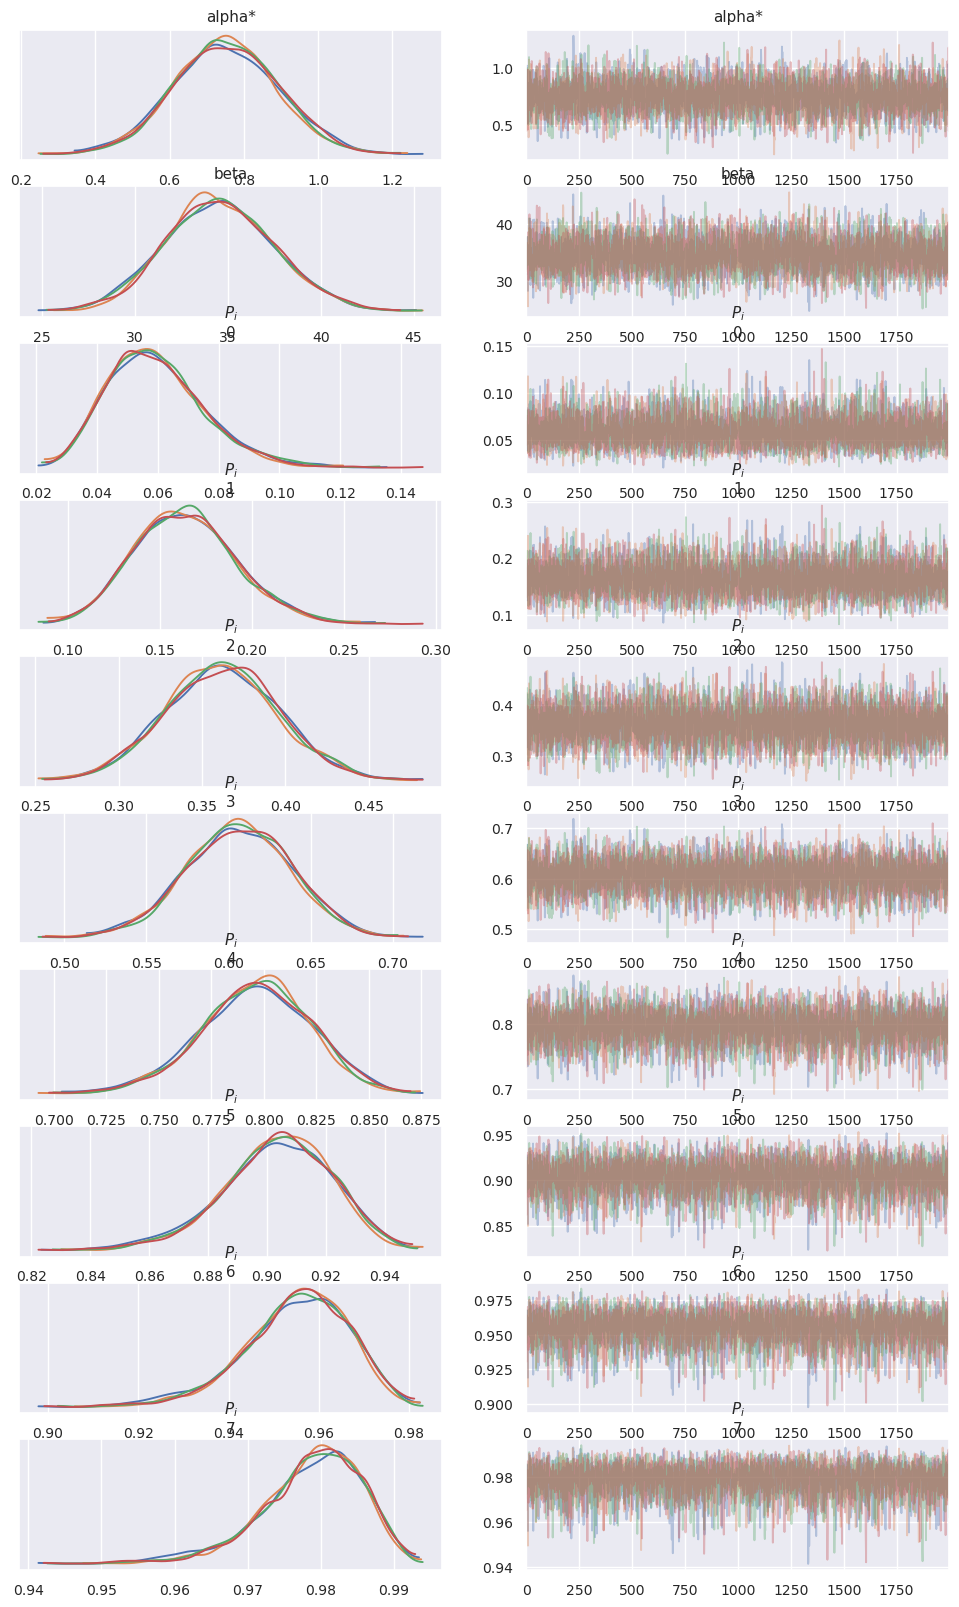

In [17]:
az.plot_trace(idtrace, compact=False);

chains : int
        The number of chains to sample. Running independent chains is important for some
        convergence statistics and can also reveal multiple modes in the posterior. If ``None``,
        then set to either ``cores`` or 2, whichever is larger.

cores : int
        The number of chains to run in parallel. If ``None``, set to the number of CPUs in the
        system, but at most 4.

In [19]:
def trace_summary(trace, var_names=None):
    if var_names is None:
        var_names = trace.varnames

    quants = [0.025,0.25,0.5,0.75,0.975]
    colnames = ['mean', 'sd', *["{}%".format(x*100) for x in quants]]
    # use * to break the list
    rownames = []

    series = []
    for cur_var in var_names:
        var_trace = trace[cur_var]
        if var_trace.ndim == 1:
            vals = [np.mean(var_trace, axis=0), np.std(var_trace, axis=0), *np.quantile(var_trace, quants, axis=0)]
            series.append(pd.Series(vals, colnames))
            rownames.append(cur_var)
        else:
            for i in range(var_trace.shape[1]):
                cur_col = var_trace[:,i]
                vals = [np.mean(cur_col, axis=0), np.std(cur_col, axis=0), *np.quantile(cur_col, quants, axis=0)]
                series.append(pd.Series(vals, colnames))
                rownames.append("{}[{}]".format(cur_var,i))

    return pd.DataFrame(series, index=rownames)

trace_summary(mttrace)

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
alpha*,0.750107,0.139548,0.483408,0.654862,0.747323,0.841259,1.031658
beta,34.527700,2.937567,28.875984,32.574628,34.489566,36.475378,40.397916
$P_i$[0],0.059523,0.016222,0.032576,0.048009,0.057598,0.069072,0.096117
$P_i$[1],0.164425,0.028310,0.112868,0.144808,0.162816,0.182316,0.223869
$P_i$[2],0.362016,0.034346,0.296231,0.338563,0.361968,0.385242,0.430285
$P_i$[3],0.605800,0.031760,0.543549,0.584710,0.605568,0.627402,0.667544
$P_i$[4],0.795665,0.026394,0.741308,0.778302,0.796249,0.813667,0.845352
$P_i$[5],0.903129,0.018839,0.861796,0.891563,0.904513,0.916216,0.936376
$P_i$[6],0.954743,0.011942,0.927489,0.947712,0.956031,0.963180,0.974503
$P_i$[7],0.978552,0.007141,0.961735,0.974584,0.979562,0.983598,0.989648


We can also plot the density each chain explored. Any major deviations between chains are signs of difficulty converging.

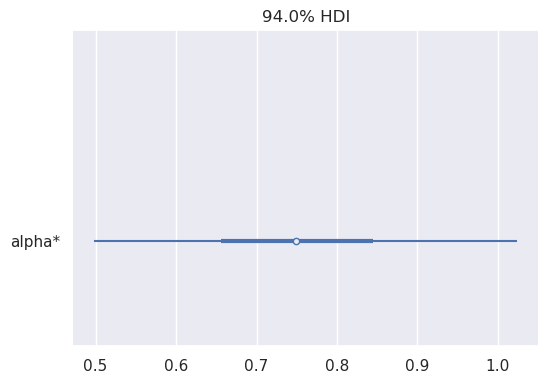

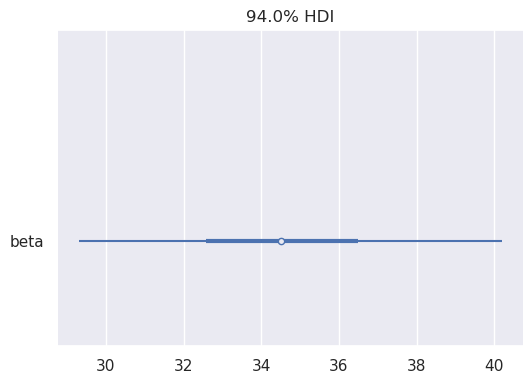

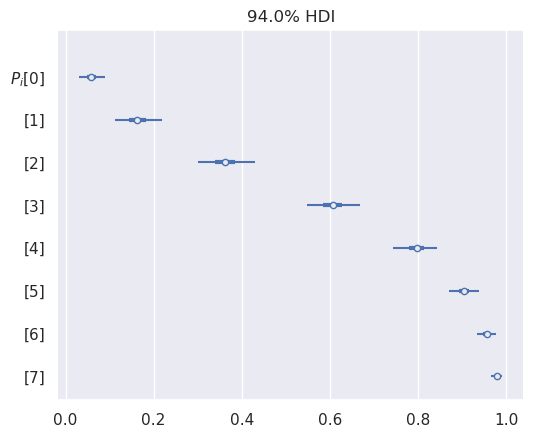

In [28]:
for x in mttrace.varnames:
    az.plot_forest(idtrace, var_names=[x], combined=True)
    # combined: Flag for combining multiple chains into a single chain. If False, chains will be plotted separately. 

In addition to the above summaries of the distribution, pymc3 has statistics intended to summarize the quality of the samples. The most common of these is r_hat, which measures whether the different chains seem to be exploring the same space or if they're stuck in different spaces. R-hat above 1.3 is a strong sign the sample isn't good yet. Values close to 1 are ideal.

In [21]:
az.summary(idtrace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha*,0.751,0.140,0.498,1.024,0.002,0.001,5735.0,5251.0,1.0
beta,34.565,2.898,29.307,40.194,0.039,0.027,5581.0,5363.0,1.0
$P_i$[0],0.059,0.016,0.031,0.090,0.000,0.000,7273.0,6028.0,1.0
$P_i$[1],0.164,0.028,0.113,0.218,0.000,0.000,7931.0,6213.0,1.0
$P_i$[2],0.362,0.034,0.300,0.429,0.000,0.000,8014.0,6028.0,1.0
$P_i$[3],0.606,0.032,0.548,0.668,0.000,0.000,6252.0,5484.0,1.0
$P_i$[4],0.796,0.026,0.742,0.842,0.000,0.000,5154.0,4754.0,1.0
$P_i$[5],0.903,0.019,0.869,0.939,0.000,0.000,4759.0,4957.0,1.0
$P_i$[6],0.955,0.012,0.934,0.977,0.000,0.000,4755.0,4756.0,1.0
$P_i$[7],0.979,0.007,0.966,0.991,0.000,0.000,4827.0,4693.0,1.0


## Sleep Study

In [22]:
import pandas as pd
sleepstudy = pd.read_csv("../data/sleepstudy.csv")

In [23]:
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


In [24]:
# adding a column that numbers the subjects from 0 to n
raw_ids = np.unique(sleepstudy['Subject'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}
# np.where: Return the indices of the elements that are non-zero. Returns a tuple of arrays


sleepstudy['SeqSubject'] = sleepstudy['Subject'].map(raw2newid)
# !!!!!!!!!!!!
sleepstudy

,Reaction,Days,Subject,SeqSubject
0,249.5600,0,308,0
1,258.7047,1,308,0
2,250.8006,2,308,0
3,321.4398,3,308,0
4,356.8519,4,308,0
...,...,...,...,...
175,329.6076,5,372,17
176,334.4818,6,372,17
177,343.2199,7,372,17
178,369.1417,8,372,17


In [54]:
with pm.Model() as sleep_model:
    
    # In this model, we're going to say the alphas (individuals' intercepts; their starting reaction time)
    # and betas (individuals' slopes; how much worse they get with lack of sleep) are normally distributed.
    # We'll specify that we're certain about the mean of those distribution [more on that later], but admit
    # we're uncertain about how much spread there is (i.e. uncertain about the SD). Tau_alpha and Tau_beta 
    # will be the respective SD.
    #
    # Of course, the SDs must be positive (negative SD isn't mathematically possible), so we draw them from
    # a Gamma, which cannot ever output negative numbers. Here, we use alpha and beta values that spread the
    # distribution: "the SD could be anything!". If we had more intuition (e.g. "the starting reaction times can't
    # have SD above 3,000") we would plot Gamma(a,b) and tune the parameters so that there was little mass
    # above 3,000, then use those values below)
    tau_alpha = pm.Gamma('tau_alpha', alpha=.001, beta=.001)
    tau_beta = pm.Gamma('tau_beta', alpha=.001, beta=.001)
    
    # Across the population of people, we suppose that
    # the slopes are normally distributed, as are the intercepts,
    # and the two are drawn independently
    #
    # (Here, we hard-code assumed means, but we don't have to.
    # In general, these should be set from our pre-data intuition,
    # rather than from plots/exploration of the data)
    alpha = pm.Normal('alpha', mu=300, tau=tau_alpha, shape=len(raw_ids))
    beta = pm.Normal('beta', mu=10, tau=tau_beta, shape=len(raw_ids))
    
    # Remember: there's only one alpha/beta per person, but
    # we have lots of observations per person. The below
    # builds a vector with one entry per observation, recording
    # the alpha/beta we want to use with that observation.
    #
    # That is, the length is 180, but it only has 17 unique values,
    # matching the 17 unique patients' personal slopes or intercepts
    intercepts = alpha[sleepstudy['SeqSubject']]
    slopes = beta[sleepstudy['SeqSubject']]
    
    # now we have the true/predicted response time for each observation (each row of original data)
    # (Here we use pm.Deterministic to signal that this is something we'll care about)
    mu_i = pm.Deterministic('mu_i', intercepts + slopes*sleepstudy['Days'])
    
    # The _observed_ values are noisy versions of the hidden true values, however! 
    # Specifically, we model them as a normal at the true value and single unknown variance
    # (one explanation: we're saying the measurement equipment adds normally-distributed noise tau_obs
    # so noise doesn't vary from observation to observation or person to person: there's just one universal
    # noise level)
    tau_obs = pm.Gamma('tau_obs', 0.001, 0.001)
    obs = pm.Normal('observed', mu=mu_i, tau=tau_obs, observed=sleepstudy['Reaction'])
    
    trace1 = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=False)
    trace2 = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_alpha, tau_beta, alpha, beta, tau_obs]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_alpha, tau_beta, alpha, beta, tau_obs]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


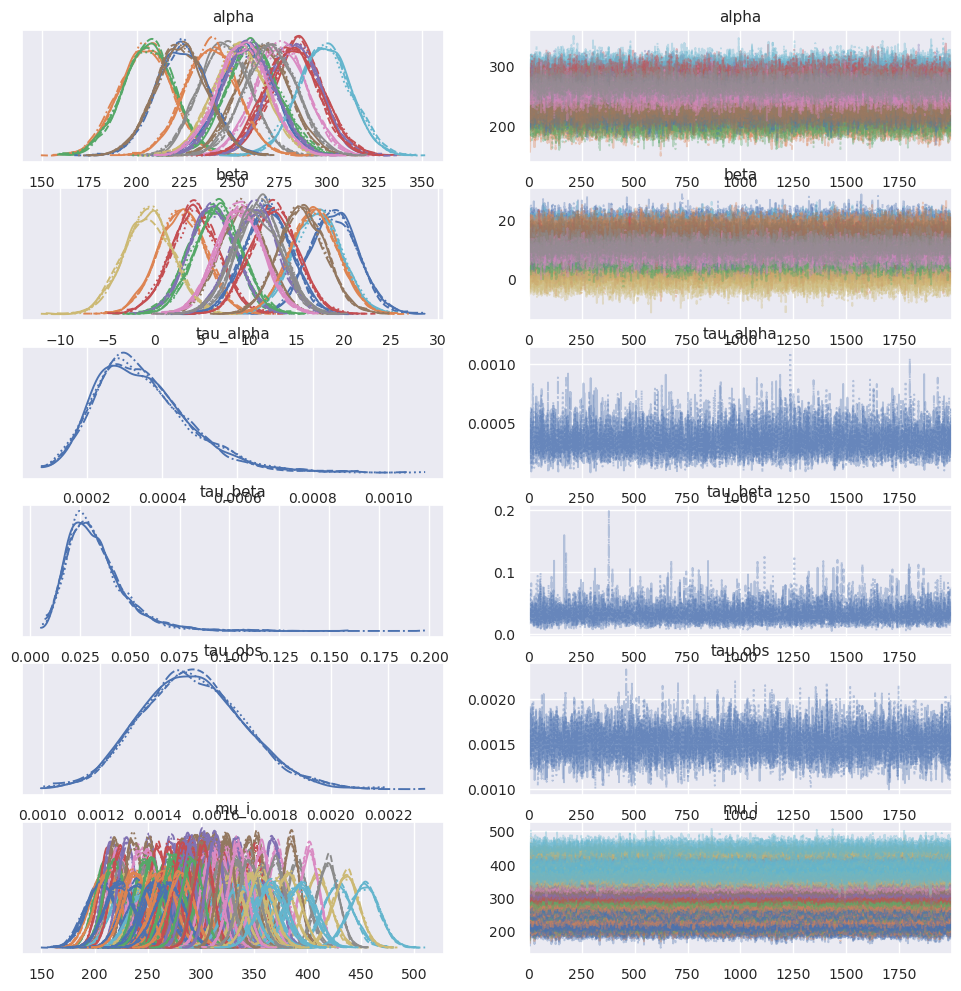

In [45]:
# this command can take a few minutes to finish... or never :-/
az.plot_trace(trace2);

In [46]:
trace_summary(trace1, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
tau_alpha,0.000351,0.000127,0.000155,0.000259,0.000334,0.000423,0.000646
tau_beta,0.033168,0.015241,0.012875,0.022678,0.030218,0.040454,0.069590
alpha[0],257.993365,14.090853,230.320222,248.392938,258.070532,267.643059,285.043773
alpha[1],204.351298,13.848083,177.527294,195.130929,204.145030,213.610245,231.550241
alpha[2],206.298763,13.741135,179.690439,196.975590,205.997638,215.713929,233.482947
alpha[3],284.339918,13.978247,257.420887,274.876584,284.181519,293.568552,311.979142
alpha[4],282.425892,13.727142,255.903948,273.104985,282.217590,291.718598,309.950193
alpha[5],266.216523,13.539424,239.188298,257.429783,266.446961,275.274380,292.640147
alpha[6],275.688835,13.663133,248.522610,266.544026,275.566268,284.954758,303.015624
alpha[7],246.077481,13.588844,219.566519,236.957906,245.919248,255.329377,272.784496


In [47]:
az.summary(trace2, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_alpha,0.000,0.000,0.000,0.001,0.000,0.000,10485.0,6026.0,1.0
tau_beta,0.033,0.015,0.011,0.061,0.000,0.000,8817.0,6495.0,1.0
alpha[0],257.922,13.887,231.699,283.326,0.122,0.086,12947.0,6293.0,1.0
alpha[1],204.658,13.893,178.931,231.218,0.130,0.093,11393.0,5888.0,1.0
alpha[2],206.188,13.796,178.215,230.646,0.121,0.086,13062.0,5862.0,1.0
alpha[3],284.412,13.906,257.212,310.030,0.125,0.089,12247.0,6261.0,1.0
alpha[4],282.607,13.409,256.392,306.747,0.115,0.081,13530.0,6307.0,1.0
alpha[5],266.094,13.703,239.063,290.773,0.121,0.086,12687.0,6088.0,1.0
alpha[6],275.674,13.539,249.997,300.803,0.119,0.084,12911.0,5945.0,1.0
alpha[7],246.090,13.312,220.771,270.170,0.112,0.080,14094.0,6394.0,1.0


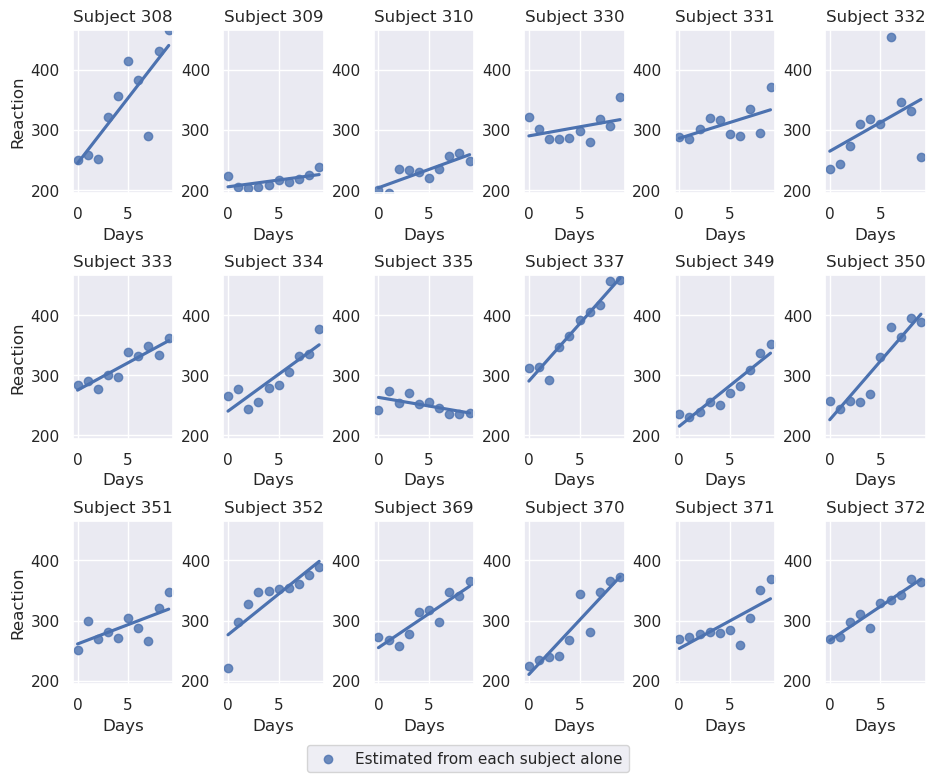

In [50]:
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec


ymin,ymax = np.min(sleepstudy["Reaction"]),np.max(sleepstudy["Reaction"])
plt.figure(figsize=(11,8.5))
gs  = gridspec.GridSpec(3, 6)
# !!!!!!!!!!!!!
gs.update(wspace=0.5, hspace=0.5)
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    # ss_extract_ols = sm.ols(formula="Reaction~Days",data=ss_extract).fit()
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    # !!!!!!!!!!!!!!
    # Plot data and a linear regression model fit.
    if i not in [0,6,12]:
        plt.ylabel("")
        # !!!!!!!!!!!!!!!!
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone'],loc = 'lower center', ncol=6)
# ncol The number of columns that the legend has.
_ = plt.show()

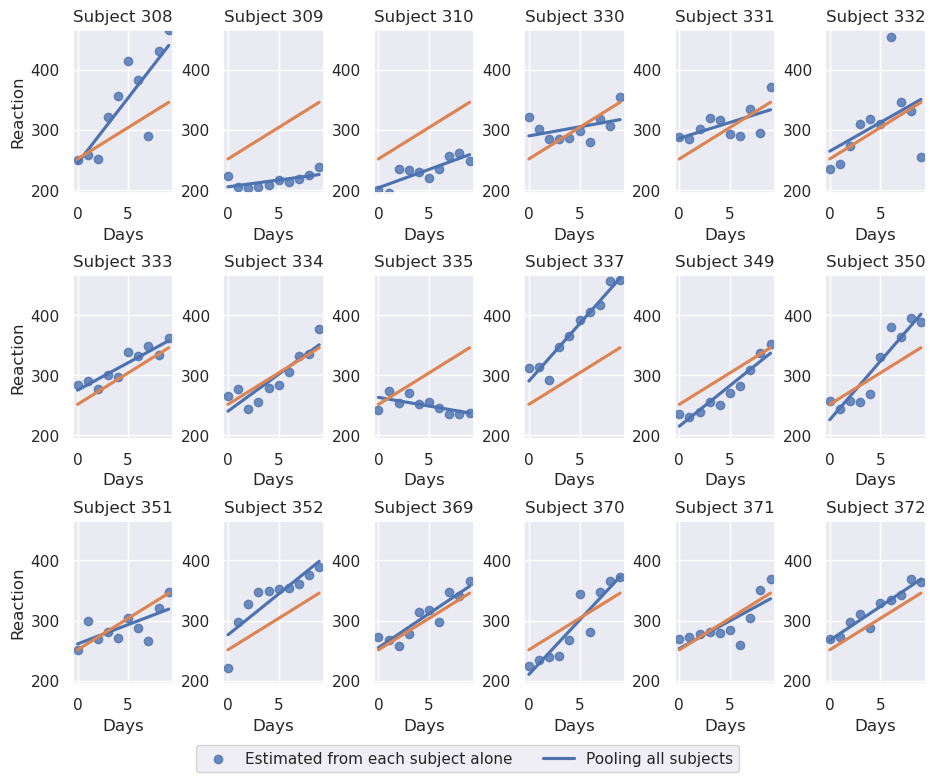

In [40]:
plt.figure(figsize=(11,8.5))
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    # !!!!!!!!!!!!!!
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects'],loc = 'lower center', ncol=6)
_ = plt.show()

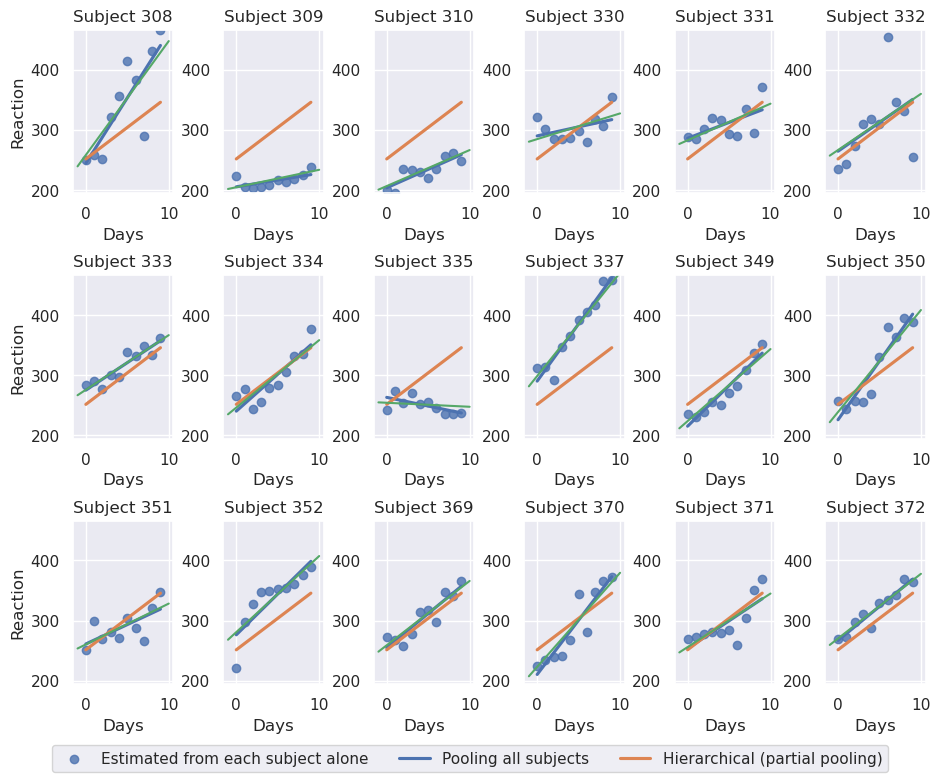

In [53]:
plt.figure(figsize=(11,8.5))
subj_arr = np.unique(sleepstudy['Subject'])
for i, subj in enumerate(subj_arr):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    
    # subj_num = int(np.where(subj_arr==subj)[0])
    
    subjects_avg_intercept = np.mean(trace1['alpha'][:,i])
    subjects_avg_slope = np.mean(trace1['beta'][:,i])
    hmodel_fit = [subjects_avg_intercept + subjects_avg_slope*x for x in range(-1,11)]
    sns.lineplot(x=range(-1,11),y=hmodel_fit)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects','Hierarchical (partial pooling)'],loc = 'lower center', ncol=6)
_ = plt.show()

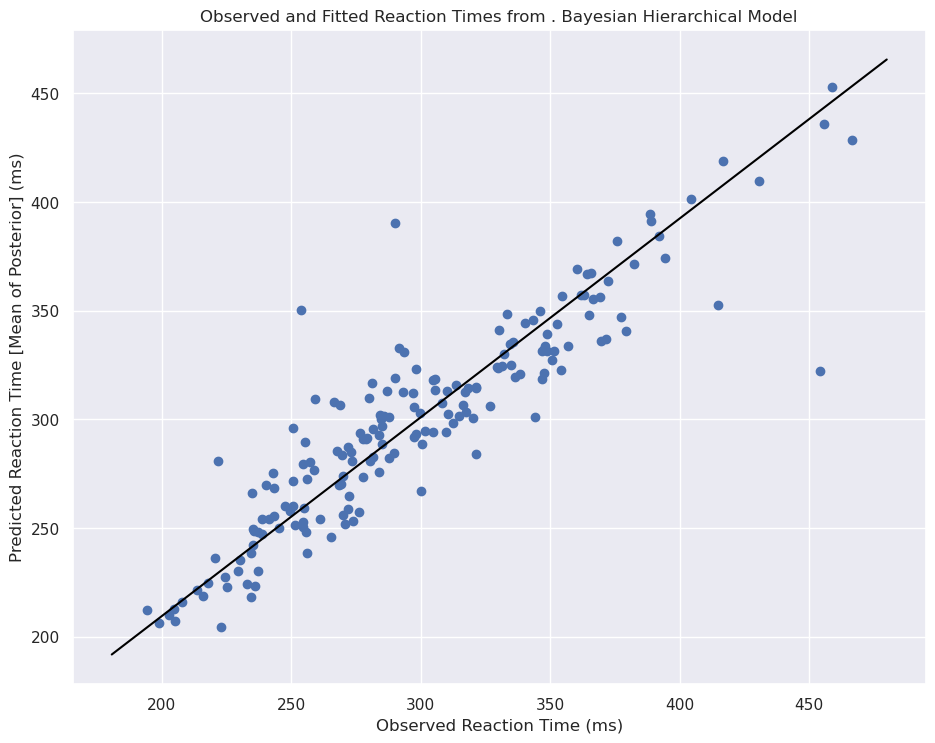

In [52]:
model_predictions = trace1['mu_i'].mean(axis=0)
obs_reactions = sleepstudy['Reaction']

plt.figure(figsize=(11,8.5))
plt.scatter(sleepstudy['Reaction'], model_predictions)
plt.plot(plt.xlim(), plt.ylim(), c='black')
plt.xlabel("Observed Reaction Time (ms)")
plt.ylabel("Predicted Reaction Time [Mean of Posterior] (ms)")
plt.title("Observed and Fitted Reaction Times from . Bayesian Hierarchical Model")
plt.show()